In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore, spearmanr
from tqdm import tqdm
from statsmodels.formula.api import ols
from alpha_191 import Alpha191

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('factor_data/all_150.csv').iloc[:,1:]
df['date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
df = df.set_index(['date']).sort_values(by=['date'])
df['vwap'] = df['amount']/df['volume']*10

In [3]:
features = ['ts_code', 'trade_date', 'open', 'close', 'high', 'low', 'log-ret', 'volume', 'amount', 'vwap',
            'turnover_rate', 'pe', 'pb', 'total_share', 'free_share', 'total_mv', 'circ_mv', 
            'name', 'industry', 'list_date','issue_price',
       'issue_amount', 'cfps', 'revenue_ps', 'gross_margin', 'dt_eps',
       'dt_eps_yoy', 'bps', 'bps_yoy', 'roe_dt','roe_yoy', 'ebt_yoy', 'or_yoy']
universe = df[features]
universe.head()

,ts_code,trade_date,open,close,high,low,log-ret,volume,amount,vwap,...,revenue_ps,gross_margin,dt_eps,dt_eps_yoy,bps,bps_yoy,roe_dt,roe_yoy,ebt_yoy,or_yoy
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,002462.SZ,20210104,13.39070,13.39070,13.43819,13.27674,-0.000709,16268.24,22877.79,14.062855,...,55.8388,1.536856e+09,0.8400,-16.8317,12.1918,3.8219,6.8494,-22.1707,-15.8849,3.0610
2021-01-04,603351.SH,20210104,22.16406,22.41681,22.59179,22.06685,0.011339,9036.36,20761.39,22.975391,...,3.9155,1.928144e+08,0.5800,-32.5581,9.7589,-26.6176,5.5476,-34.2804,-31.8282,-22.5666
2021-01-04,002864.SZ,20210104,24.79540,24.95352,24.97329,24.41986,0.005162,8293.00,20773.88,25.049898,...,5.2071,2.857285e+08,0.7650,14.2132,8.1652,4.8864,8.6984,6.2152,17.6305,3.5549
2021-01-04,002900.SZ,20210104,9.00744,9.10471,9.12417,8.96853,0.011822,9622.00,8957.31,9.309198,...,3.0526,6.291739e+08,0.0700,-85.4167,5.5847,-3.5241,-1.1958,-84.9297,-84.1369,-40.7487
2021-01-04,002737.SZ,20210104,13.72530,13.65977,13.72530,13.50997,-0.005468,53154.98,77148.28,14.513839,...,3.7780,1.240165e+09,0.5439,-15.1482,5.0342,-8.8139,9.4400,-11.6328,-20.2794,-29.9823


### Get Alpha Factors

In [4]:
#benchmark_df = pd.read_csv('tushare_data/benchmark_20180101_20230407.csv').iloc[:,1:]
al = Alpha191(universe,None)

100%|████████████████████████████████████████| 548/548 [00:01<00:00, 345.96it/s]


## Alpha 191

Common Functions

In [5]:
from scipy.stats import rankdata

## calculate correlation bettwen two series in a rolling period time
def Corr(data, win_len):
    obj = data.rolling(window=win_len, method='table')
    s = []
    for o in obj:
        if o.shape[0] < win_len:
            s.append(0.)
        else:
            s.append(spearmanr(o.iloc[:,0], o.iloc[:,1])[0])
            #s.append(o.iloc[:, 0].corr(o.iloc[:, 1]))
    return pd.DataFrame(s, index=data.index, columns=['corr'])

def Decaylinear(sr, window):
    weights = np.array(range(1, window+1))
    sum_weights = np.sum(weights)
    return sr.rolling(window).apply(lambda x: np.sum(weights*x) / sum_weights)

## calculate series rank in a rolling period time and get last time rank value
def Tsrank(sr, window):
    return sr.rolling(window).apply(lambda x: rankdata(x)[-1])

def Sma(sr, n, m):
    return sr.ewm(alpha=m / n, adjust=False).mean()

def Sequence(n):
    return np.arange(1, n + 1)

def Wma(sr, window):
    weights = np.array(range(window - 1, -1, -1))
    weights = np.power(0.9, weights)
    sum_weights = np.sum(weights)
    return sr.rolling(window).apply(lambda x: np.sum(weights * x) / sum_weights)

def Regbeta(sr, x):
    window = len(x)
    return sr.rolling(window).apply(lambda y: np.polyfit(x, y, deg=1)[0])

def RegResi(df, fama_df):
    #pd.DataFrame.merge()
    estu = fama_df.loc[df.index].copy()
    estu = df.merge(estu, on=['date'])
    estu = estu.rename(columns={'log-ret':'ret'})
    form = 'ret ~ SMB + HML + MKT'
    model = ols(form, data=estu)
    results = model.fit()
    return results.params.Intercept

def Cov(x, y, window):
    return x.rolling(window).cov(y)
#tmp = universe.loc[universe.ts_code=='603538.SH']
#result = RegResi(tmp, fama_df)

def Lowday(sr, window):
    return sr.rolling(window).apply(lambda x: len(x) - x.values.argmin())


def Highday(sr, window):
    return sr.rolling(window).apply(lambda x: len(x) - x.values.argmax())

Alpha factors calculate

In [27]:
# need nothing (good)
def alpha035(df):
    ## 寻找开盘价长期高点或量价背离最大化取保守值
    ####(MIN(RANK(DECAYLINEAR(DELTA(OPEN, 1), 15)), RANK(DECAYLINEAR(CORR((VOLUME), ((OPEN * 0.65) +(OPEN *0.35)), 17),7))) * -1)###
    def cal_(df):
        df['section1'] = Decaylinear(df['open'].diff(1), 15)
        df['section2'] = df['open'] * 0.65 + df['high'] * 0.35
        df['section2'] = -Decaylinear(Corr(df[['volume', 'section2']], 17)['corr'], 7)
        return df

    df_all = pd.DataFrame()
    for ts_code in tqdm(df.ts_code.unique(), desc='processing...'):
        tmp = df.loc[df.ts_code == ts_code]
        tmp = cal_(tmp)
        df_all = df_all.append(tmp)

    def rescale_(df):
        df['section1'] = (df['section1'] - df['section1'].mean())/df['section1'].std()
        df['section2'] = (df['section2'] - df['section2'].mean())/df['section2'].std()
        df['alpha_035'] = -np.where(df['section1'] < df['section2'], df['section1'], df['section2'])
        df['alpha_035'] = df['alpha_035'].rank(method='min', pct=True)
        return df
    df_all = df_all.groupby('trade_date').apply(rescale_)
    #df_all['alpha_035'] = -np.where(df_all['section1'] < df_all['section2'], df_all['section1'], df_all['section2'])
    df_all = df_all.drop(columns=['section1', 'section2'])

    return df_all

def alpha116(df):
    ####REGBETA(CLOSE,SEQUENCE,20)###
    def cal_(df):
        df['alpha_116'] = Regbeta(df['close'], Sequence(20)**1.2)
        return df
        
    df_all = pd.DataFrame()
    for ts_code in tqdm(df.ts_code.unique(), desc='processing...'):
        tmp = df.loc[df.ts_code == ts_code]
        tmp = cal_(tmp)
        df_all = df_all.append(tmp)
    
    df_all[['alpha_116']] = df_all.groupby('trade_date')[['alpha_116']].rank(method='min', pct=True)
    
    return df_all

def alpha119(df):
    ####(RANK(DECAYLINEAR(CORR(VWAP, SUM(MEAN(VOLUME,5), 26), 5), 7)) - RANK(DECAYLINEAR(TSRANK(MIN(CORR(RANK(OPEN), RANK(MEAN(VOLUME,15)), 21), 9), 7), 8)))###
    def cal_(df):
        section1 = (df['volume'].rolling(5).mean()).rolling(26).sum()
        df['section1'] = Decaylinear(Corr(pd.concat([section1, df['vwap']],axis=1), 5)['corr'], 7)
        df['section2'] = df['volume'].rolling(15).mean()
        return df
    
    df_all = pd.DataFrame()
    for ts_code in tqdm(df.ts_code.unique(), desc='processing1...'):
        tmp = df.loc[df.ts_code == ts_code]
        tmp = cal_(tmp)
        df_all = df_all.append(tmp)
    
    df_all[['section1', 'section2', 'section3']] = df_all.groupby('trade_date')[['section1', 'section2', 'open']].rank()
    
    def cal2_(df):
        df['section2'] = Decaylinear(Tsrank(Corr(df[['section2', 'section3']], 21)['corr'].rolling(9).min(), 7), 8)
        return df
    
    df = pd.DataFrame()
    for ts_code in tqdm(df_all.ts_code.unique(), desc='processing2...'):
        tmp = df_all.loc[df_all.ts_code == ts_code]
        tmp = cal2_(tmp)
        df = df.append(tmp)
    df['alpha_119'] = df['section1'] - df['section2'] 
    df = df.drop(columns=['section1', 'section2', 'section3'])
    
    return df

def alpha128(df):
    
    def cal_(df):
    #### 100-(100/(1+SUM(((HIGH+LOW+CLOSE)/3>DELAY((HIGH+LOW+CLOSE)/3,1)?(HIGH+LOW+CLOSE)/3*VOLUME:0),14)/SUM(((HIGH+LOW+CLOSE)/3<DELAY((HIGH+LOW+CLOSE)/3,1)?(HIGH+LOW+CLOSE)/3*VOLUME:0),14)))
        A = (df['low'] + df['close']) / 2
        section1 = pd.Series(np.where(A>A.shift(1), A * df['volume'], 0), index=df.index)
        section2 = pd.Series(np.where(A<=A.shift(1), A * df['volume'], 0), index=df.index)
        df['alpha_128'] = 100 - (100 / (1 + section1.rolling(14).sum() / section2.rolling(14).sum()))
        return df
    
    df = df.groupby('ts_code').apply(cal_)
    #df[['alpha_128']] = df.groupby('trade_date')[['alpha_128']].rank().apply(zscore)
    return df

def alpha172(df):
    ####MEAN(ABS(SUM((LD>0 & LD>HD)?LD:0,14)*100/SUM(TR,14)-SUM((HD>0 &HD>LD)?HD:0,14)*100/SUM(TR,14))/(SUM((LD>0 & LD>HD)?LD:0,14)*100/SUM(TR,14)+SUM((HD>0 &HD>LD)?HD:0,14)*100/SUM(TR,14))*100,6)
    def cal_(df):
        TR1 = df['high'] - df['low']
        TR2 = (df['high'] - df['close'].shift(1)).abs()
        TR3 = (df['low'] - df['close'].shift(1)).abs()
        TR = pd.Series(np.maximum(np.maximum(TR1, TR2), TR3), index=df.index)
        HD = df['high'] - df['high'].shift(1)
        LD = df['low'].shift(1) - df['low']
        cond1 = ((LD > 0) & (LD > HD))
        cond2 = ((HD > 0) & (HD > LD))
        part1 = pd.Series(np.where(cond1, LD, 0), index=df.index)
        part2 = pd.Series(np.where(cond2, HD, 0), index=df.index)
        df['alpha_172'] = ((part1.rolling(14).sum() - part2.rolling(14).sum()) / TR.rolling(14).sum()).abs()
        df['alpha_172'] = df['alpha_172'] / ((part1.rolling(14).sum() + part2.rolling(14).sum()) / TR.rolling(14).sum())
        df['alpha_172'] = df['alpha_172'].rolling(6).mean()
        return df
    
    df = df.groupby('ts_code').apply(cal_)
    return df

## excellent
def alpha176(df):  # 1678
    ## 短线量价关系
    ####CORR(RANK(((CLOSE - TSMIN(LOW, 12)) / (TSMAX(HIGH, 12) - TSMIN(LOW,12)))), RANK(VOLUME), 6)###
    def cal_(df):
        df['section1'] = (df['close'] - df['low'].rolling(12).min()) \
                        / (df['high'].rolling(12).max() - df['low'].rolling(12).min())
        df['section2'] = pd.Series(np.log(df['volume']), index=df.index)
        return df
    
    df = df.groupby('ts_code').apply(cal_)
    df[['section1', 'section2']] = df.groupby('trade_date')[['section1', 'section2']].rank()
    
    df_all = pd.DataFrame()
    for ts_code in tqdm(df.ts_code.unique(), desc='processing...'):
        tmp = df.loc[df.ts_code == ts_code]
        tmp['alpha_176'] = Corr(tmp[['section1', 'section2']], 12)['corr']
        df_all = df_all.append(tmp)
    
    df_all = df_all.drop(columns=['section1', 'section2'])
    return df_all

def alpha181(df):  # 1532  公式有问题，假设后面的sum周期为20
    ####SUM(((CLOSE/DELAY(CLOSE,1)-1)-MEAN((CLOSE/DELAY(CLOSE,1)-1),20))-(BANCHMARKINDEXCLOSE-MEAN(BANCHMARKINDEXCLOSE,20))^2,20)/SUM((BANCHMARKINDEXCLOSE-MEAN(BANCHMARKINDEXCLOSE,20))^3)###
    def cal_(df):
        benchmark_return_acc = al.benchmark_return[df.index].cumsum()
        return_acc = df['log-ret'].cumsum()
        section1 = (return_acc - return_acc.rolling(20).mean()) - (benchmark_return_acc - benchmark_return_acc.rolling(20).mean()) **2
        section1 = section1.rolling(20).sum()
        section2 = (benchmark_return_acc - benchmark_return_acc.rolling(20).mean()) ** 3
        section2 = section2.rolling(20).sum()
        df['alpha_181'] = section1 / section2
        return df
    
    df = df.groupby('ts_code').apply(cal_)
    df['alpha_181'] = df.groupby('trade_date')['alpha_181'].rank(method='min', pct=True)
    return df

def alpha_cus002(df):
#     if 'alpha_149' not in df:
#         df = self.alpha149(df)
#     if 'alpha_075' not in df:
#         df = self.alpha075(df)

    df['alpha_cus002'] = df['alpha_149'] - df['alpha_075']
    df['alpha_cus002'] = df.groupby('trade_date')['alpha_cus002'].rank(method='min', pct=True)
    return df

def alpha182(df):
    ####COUNT((CLOSE>OPEN & BANCHMARKINDEXCLOSE>BANCHMARKINDEXOPEN)OR(CLOSE<OPEN & BANCHMARKINDEXCLOSE<BANCHMARKINDEXOPEN),20)/20###
    def cal_(df):
        benchmark_close = al.benchmark_close[df.index].copy()
        benchmark_open = al.benchmark_open[df.index].copy()
        cond1 = ((df['close'] > df['open']) & (benchmark_close > benchmark_open))
        cond2 = ((df['close'] < df['open']) & (benchmark_close < benchmark_open))
        df['alpha_182'] = np.where((cond1|cond2), 1, 0)
        df['alpha_182'] = df['alpha_182'].rolling(20).mean()
        return df
    
    df = df.groupby('ts_code').apply(cal_)
    return df

def alpha_190(df):
    
    def cal_(df):
        sub1 = df['close']/df['close'].shift(1)
        sub2 = df['close']/df['close'].shift(19)
        section1 = pd.Series(np.where(sub1 > (sub2 ** (1/20) - 1), 1, 0), index=df.index)
        section1 = section1.rolling(20).sum() -1
        
        section2 = pd.Series(np.where(sub1 < (sub2 ** (1/20)), (sub1 - (sub2 ** (1/20) -1)) ** 2, 0), index=df.index)
        section2 = section2.rolling(20).sum()
        
        section3 = section1 + 1
        section4 = pd.Series(np.where(sub1 > (sub2 ** (1/20)), (sub1 - (sub2 ** (1/20) -1)) ** 2, 0), index=df.index)
        section4 = section4.rolling(20).sum()
        df['alpha_190'] = np.log(section1 * section2 / (section3 * section4))
        return df
    
    df = df.groupby('ts_code').apply(cal_)
    return df
    
    

In [44]:
#universe = al.alpha030(universe)
#universe = al.alpha075(universe)
#universe = al.alpha101(universe)
#universe = alpha137(universe)
#universe = al.alpha075(universe)
universe = alpha176(universe)
universe.ts_code.unique()[:20]

processing...: 100%|██████████████████████████| 150/150 [00:59<00:00,  2.52it/s]


array(['000411.SZ', '000705.SZ', '000756.SZ', '000915.SZ', '000919.SZ',
       '000952.SZ', '002020.SZ', '002022.SZ', '002166.SZ', '002275.SZ',
       '002365.SZ', '002393.SZ', '002435.SZ', '002462.SZ', '002562.SZ',
       '002626.SZ', '002727.SZ', '002728.SZ', '002737.SZ', '002788.SZ'],
      dtype=object)

In [29]:
con1 = universe['alpha_190'].isnull()==False
con2 = universe['trade_date'] == 20230407
universe.loc[con1 & con2].sort_values(by=['alpha_190']).tail(10)

,ts_code,trade_date,open,close,high,low,log-ret,volume,amount,vwap,...,roe_yoy,ebt_yoy,or_yoy,rsize,rvalue,alpha_182,alpha_149,alpha_030,alpha_075,alpha_190
date,,,,,,,,,,,,,,,,,,,,,
2023-04-07,603669.SH,20230407,5.42,5.52,5.53,5.39,0.025689,22679.97,12426.89,5.479236,...,-200.5428,-174.3028,-61.5873,0.280000,0.746667,0.65,0.269628,0.303490,0.088435,0.314518
2023-04-07,603108.SH,20230407,13.65,13.88,14.03,13.50,0.016709,272846.60,376569.16,13.801497,...,-15.0151,1.4776,14.9753,0.673333,0.360000,0.75,0.006118,0.460170,0.421769,0.435800
2023-04-07,600211.SH,20230407,56.96,55.36,56.96,54.58,-0.031997,49587.07,275250.05,55.508432,...,54.5811,81.8283,19.4532,0.840000,0.946667,0.50,0.080566,0.390514,0.986395,0.444575
2023-04-07,000028.SZ,20230407,46.60,46.50,47.80,45.95,0.000000,27186.35,127156.72,46.772266,...,-8.9000,-1.8966,8.7766,0.980000,0.040000,0.55,0.026192,0.399227,0.986395,0.466520
2023-04-07,300406.SZ,20230407,21.10,21.13,21.20,20.80,0.000947,42766.14,89966.22,21.036788,...,-4.6812,-26.1086,-7.8631,0.806667,0.893333,0.65,0.118460,0.698598,0.421769,0.488397
2023-04-07,002022.SZ,20230407,12.94,12.93,12.96,12.66,0.004651,93079.22,119027.35,12.787747,...,-8.1857,26.1256,43.5809,0.546667,0.113333,0.50,-0.041391,0.014861,0.979592,0.491350
2023-04-07,300391.SZ,20230407,8.34,8.49,8.77,8.31,0.011848,80688.52,69153.70,8.570451,...,-70.9482,-31.1585,-21.7584,0.133333,0.780000,0.80,0.100078,0.535442,0.088435,0.511555
2023-04-07,300497.SZ,20230407,12.99,13.12,13.28,12.98,0.011499,75190.46,98996.83,13.166142,...,-69.5057,-75.5796,15.5941,0.613333,0.473333,0.80,0.231246,0.604356,0.006803,0.729200
2023-04-07,688117.SH,20230407,33.25,32.50,33.69,32.01,-0.018293,22664.03,74694.31,32.957206,...,-13.2451,-8.7399,-6.6958,0.060000,0.666667,0.65,0.042145,0.420546,0.421769,0.969078


<AxesSubplot:title={'center':'alpha_176'}, xlabel='date'>

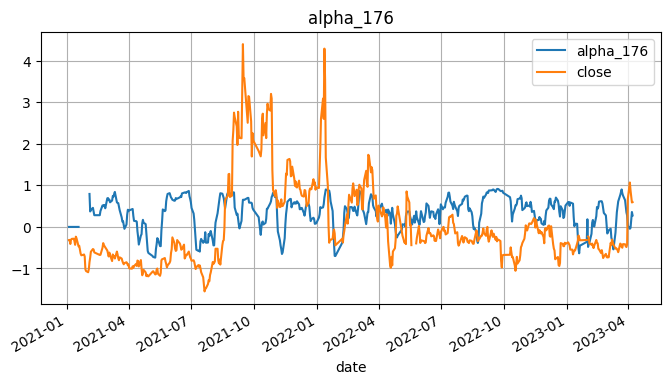

In [60]:
### benchmark_close.plot()
#benchmark_open.plot() 17 21 23
name = 'alpha_176'

# & (universe['trade_date']>20190901) 
rescale_universe = universe.copy()

#rescale_universe[[name]] = rescale_universe.groupby('trade_date')[[name]].rank(method='min', pct=True)#.apply(zscore)
#rescale_universe[name] = (rescale_universe[name] - 0.5) * 2

#rescale_universe = rescale_universe.groupby('ts_code').apply(rescale_, 60)
# 'alpha_149'
tmp = rescale_universe.loc[(rescale_universe.ts_code=='300497.SZ') & (rescale_universe['trade_date']>20200101)][[name,'close']]
#tmp[['close',name]] = tmp[['close', name]].apply(zscore)
tmp[['close']] = tmp[['close']].apply(zscore)
tmp['close'] = tmp['close'].shift(-5)
tmp.plot(title=name, grid=True)
#tmp['close'].rank(method='min', pct=True).plot()

<AxesSubplot:>

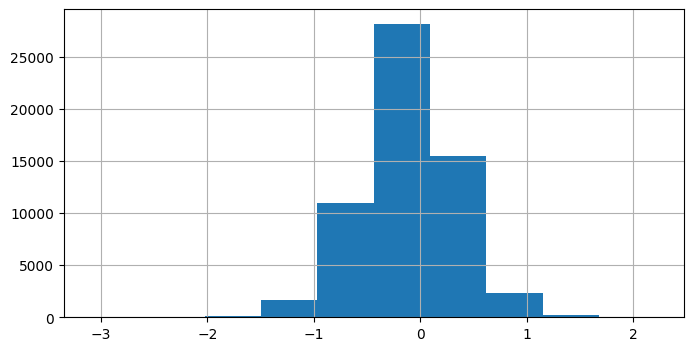

In [35]:
rescale_universe['alpha_190'] = rescale_universe['alpha_190'].replace([-np.inf, np.inf], 0)
rescale_universe['alpha_190'].hist()

In [ ]:
#universe.loc[universe.ts_code=='603538.SH'][['amount','volume','vwap']]
universe.loc[(universe.ts_code=='688117.SH')& (universe['trade_date']>20180101)][name].plot()

In [ ]:
universe.alpha_030.hist()